In [1]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from mc_plot_utils import MCMCResult

In [6]:
import mc_plot_utils

In [7]:
surp.set_yields()

In [8]:
df = pd.read_csv("yield_fits.tsv", sep=r"\s+", comment="#")
df

,model,y0,zeta0,zeta0_err,zeta1,zeta1_err
0,fruity,3.110,3.7,0.3,-3.5,0.3
1,aton,-0.009,1.0,1.9,-10.0,3.0
2,monash,2.960,2.3,0.5,-11.0,1.0
3,nugrid,9.250,8.1,1.9,-4.6,1.7
4,fruity_mf0.5,2.830,3.3,0.2,-1.8,0.2
5,fruity_mf0.7,3.600,4.2,0.3,-3.1,0.3
6,fruity_mf1.5,3.110,3.4,0.2,-3.0,0.2


In [9]:
vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", mass_factor=0.7)
surp.yields.calc_y(surp.Z_SUN, kind="agb") * 1e3

0.3604729682654721

In [10]:
yagb_props = {}

for _, row in df.iterrows():
    yagb_props[row.model] = {
        "y0": row.y0 * 1e-4,
        "y_a": row.zeta0 * 0e-4,
        "zeta_a": row.zeta1 * 0e-4,
    }

yagb_props["analytic"] = {
    "y0": 1e-3,
    "y_a": 1e-3,
    "zeta_a": 1e-3
}

yagb_props

{'fruity': {'y0': 0.000311, 'y_a': 0.0, 'zeta_a': -0.0},
 'aton': {'y0': -9e-07, 'y_a': 0.0, 'zeta_a': -0.0},
 'monash': {'y0': 0.000296, 'y_a': 0.0, 'zeta_a': -0.0},
 'nugrid': {'y0': 0.000925, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf0.5': {'y0': 0.000283, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf0.7': {'y0': 0.00036, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf1.5': {'y0': 0.000311, 'y_a': 0.0, 'zeta_a': -0.0},
 'analytic': {'y0': 0.001, 'y_a': 0.001, 'zeta_a': 0.001}}

In [11]:
def load_model(filename, props, test=False, burn=0, **kwargs):
    y0 = props["y0"],
    y_a = props["y_a"]
    zeta_a = props["zeta_a"]
    
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename + "/", y0=y0, burn=burn, y_a=y_a, zeta_a=zeta_a, **kwargs)
    return result

# Body

## Main comparisons

In [12]:
results = {}

In [13]:
results["fiducial"] = load_model("fiducial", yagb_props["fruity"])

In [14]:
results["4spline"] = load_model("4spline/fiducial", yagb_props["fruity"], y0_keys={"spline_2": 1e-3})

In [119]:
results["4spline_monash"] = load_model("4spline/monash", yagb_props["monash"], y0_keys={"spline_2": 1e-3})

In [16]:
results["4spline_nugrid"] = load_model("4spline/nugrid", yagb_props["nugrid"], y0_keys={"spline_2": 1e-3})

In [17]:
results["4spline_aton"] = load_model("4spline/aton", yagb_props["aton"], y0_keys={"spline_2": 1e-3})

In [21]:
results["4spline_v21"] = load_model("4spline/vincenzo21", yagb_props["fruity"], y0_keys={"spline_2": 1e-3})

In [22]:
results["4spline_gso"] = load_model("4spline/gso", yagb_props["fruity"], y0_keys={"spline_2": 1e-3})

In [23]:
results["4spline_galah"] = load_model("4spline/galah", yagb_props["fruity"], y0_keys={"spline_2": 1e-3})

In [24]:
results["fiducial_sigma"] = load_model("fiducial_sigma0.05", yagb_props["fruity"])

In [25]:
results["fiducial_spline"] = load_model("fiducial_spline", yagb_props["fruity"],  y0_keys={"spline_5": 1e-3})

In [26]:
results["fiducial_1d"] = load_model("../mcmc_models_1d/fiducial", yagb_props["fruity"])

In [27]:
results["fiducial_spline_1d"] = load_model("../mcmc_models_1d/fiducial_spline", yagb_props["fruity"],  y0_keys={"spline_5": 1e-3})

In [28]:
results["fruity_mf0.7_spline"] = load_model("fruity_mf0.7_spline", yagb_props["fruity_mf0.7"],  y0_keys={"spline_5": 1e-3})

In [29]:
results["fiducial_constrained"] = load_model("fiducial_constrained", yagb_props["fruity"])

In [30]:
results["fiducial_constrained_sigma"] = load_model("fiducial_constrained_sigma0.05", yagb_props["fruity"])

In [31]:
results["eta2"] = load_model("eta2", yagb_props["fruity"])

In [32]:
results["eta2_constrained"] = load_model("eta2_constrained", yagb_props["fruity"])

In [33]:
results["lateburst"] = load_model("lateburst", yagb_props["fruity"])

In [34]:
results["lateburst_constrained"] = load_model("lateburst_constrained", yagb_props["fruity"])

In [35]:
results["twoinfall"] = load_model("twoinfall", yagb_props["fruity"])

In [36]:
results["twoinfall_constrained"] = load_model("twoinfall_constrained", yagb_props["fruity"])

In [37]:
results["sneia_1.2"] = load_model("sneia_1.2", yagb_props["fruity"])

In [38]:
results["sneia_1.2_constrained"] = load_model("sneia_1.2_constrained", yagb_props["fruity"])

## Agb models

In [47]:
results["fruity"] = load_model("fiducial", yagb_props["fruity"])

In [48]:
results["fruity_sigma"] = load_model("fiducial_sigma0.05", yagb_props["fruity"])

In [49]:
results["fruity_m0.7"] = load_model("fruity_mf0.7", yagb_props["fruity_mf0.7"])

In [50]:
results["fruity_m0.7_sigma"] = load_model("fruity_mf0.7_sigma0.05", yagb_props["fruity_mf0.7"])

In [51]:
#results["fruity_lin"] = load_model("fruity_lin", yagb_props["fruity"])

In [52]:
results["aton"] = load_model("aton", yagb_props["aton"])

In [53]:
results["aton_sigma"] = load_model("aton_sigma0.05", yagb_props["aton"])

In [54]:
results["aton_constrained"] = load_model("aton_constrained", yagb_props["aton"])

In [55]:
results["monash"] = load_model("monash", yagb_props["monash"])

In [56]:
results["monash_sigma"] = load_model("monash_sigma0.05", yagb_props["monash"])

In [57]:
results["monash_constrained"] = load_model("monash_constrained", yagb_props["monash"])

In [58]:
results["nugrid"] = load_model("nugrid", yagb_props["nugrid"])

In [59]:
results["nugrid_constrained"] = load_model("nugrid_constrained", yagb_props["nugrid"])

In [60]:
results["nugrid_sigma"] = load_model("nugrid_sigma0.05", yagb_props["nugrid"])

## Surveys

In [67]:
results["v21"] = load_model("fiducial_vincenzo", yagb_props["fruity"])

In [68]:
results["v21_constrained"] = load_model("fiducial_vincenzo_constrained", yagb_props["fruity"], y0_shift=0)

In [69]:
results["gso"] = load_model("fiducial_gso", yagb_props["fruity"])

In [70]:
results["gso_constrained"] = load_model("fiducial_gso_constrained", yagb_props["fruity"], y0_shift=0)

In [71]:
results["galah"] = load_model("fiducial_galah", yagb_props["fruity"])

In [72]:
results["galah_constrained"] = load_model("fiducial_galah_constrained", yagb_props["fruity"], y0_shift=0)

## Test Cases

In [ ]:
test_results = {}

In [ ]:
test_results["NUTS"] = plot_all("NUTS", test=True)

In [ ]:
test_results["HMC"] = plot_all("HMC", test=True)

In [ ]:
test_results["RWMH"] = plot_all("RWMH", test=True)

In [ ]:
test_results["both_sigma"] = plot_all("both_sigma", test=True)

In [ ]:
test_results["fine_bins"] = plot_all("fine_bins", test=True)

In [ ]:
test_results["superfine_bins"] = plot_all("superfine_bins", test=True)

In [ ]:
test_results["both_sigma"] = plot_all("both_sigma", test=True)

In [ ]:
test_results["equal_num_bins"] = plot_all("equal_num_bins", test=True)

In [ ]:
test_results["add_rand_scatter"] = plot_all("add_rand_scatter", test=True)

In [ ]:
test_results["equalnum_fine"] = plot_all("equalnum_fine", test=True)

In [ ]:
test_results["equal_num_bins"] = plot_all("equal_num_bins", test=True)

In [ ]:
test_results["t_test"] = plot_all("t_test", test=True)

In [ ]:
test_results["kstest_samples"] = plot_all("ks_test", test=True)

In [ ]:
test_results["2s"] = plot_all("both_sigma", test=True)

# Plot Utils

In [39]:
def hline_axis(ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.spines[['bottom', 'top']].set_visible(False)
    plt.axhline(0.5, color=label, linestyle=":")
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

def hide_y_decorations(ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

def hide_x_decorations(ax=None):
    ax.spines[['bottom', 'top']].set_visible(False)
    ax.xaxis.set_visible(False)

In [94]:
def compare_param_hists(results, plot_labels, var, colors=arya.COLORS, kwargs={}):
    Nr = len(plot_labels)
    fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})
    
    for i, (key, label) in enumerate(plot_labels.items()):
        ax = axs[i]
        plt.sca(ax)
        
        if key == "hline":
            hline_axis(axs[i])
            continue

        kwargs_i = kwargs.get(key, {"color": colors[i % len(colors)]})
        
        result = results[key]

        plt.hist(result.samples[var], lw=1, density=True, **kwargs_i)
        plt.ylabel(label, rotation=0, ha="right", va="center")
        
        if i == 0:
            # top axis
            ax.spines[['bottom']].set_visible(False)
            ax.tick_params(axis='x',  bottom=False, which="both")
        elif i == Nr - 1:
            # bottom axis
            ax.spines[['top']].set_visible(False)
            ax.tick_params(axis='x',  top=False, which="both")
            plt.xlabel(var)
        else:
            # middle axis
            hide_x_decorations(ax)

        hide_y_decorations(ax)
        plt.ylim(-0.1)



In [41]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


In [42]:
[1.0 for i in range(2)].append(0.2)

In [43]:
a = [2, 2, 2]
a.insert(0, 1)
a

[1, 2, 2, 2]

In [110]:
def compare_multi_param_hists(results, plot_labels, variables=["f_agb", "y0_cc", "zeta_cc"], colors=arya.COLORS, kwargs={}):
    Nr = len(plot_labels)
    Nc = len(variables)

    hs = [1.0 for i in range(Nr)]
    hs.append(0.2)
    hs.insert(0, 0.2)
    fig, axs = plt.subplots(Nr+2, Nc, figsize=(1*Nc, 0.3*Nr), sharex="col", height_ratios=hs, gridspec_kw={"hspace": 0, "wspace": 0, })

    for i, (key, label) in enumerate(plot_labels.items()):

        for j in range(Nc):
            ax = axs[i+1, j]
            plt.sca(ax)
            
            if key == "hline":
                hline_axis(ax)
                continue
    
            kwargs_i = kwargs.get(key, {"facecolor": colors[i % len(colors)]})
            result = results[key]
            
            var = variables[j]
            if var in result.samples.columns:
                plt.hist(result.samples[var], linewidth=0.1, edgecolor="black", histtype="stepfilled", density=True, **kwargs_i)

            if j == 0:
                plt.ylabel(label, rotation=0, ha="right", va="center")

            # middle axis
            hide_x_decorations(ax)
    
            hide_y_decorations(ax)

    for j in range(Nc):
        ax = axs[-1, j]
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")
        ax.set_xlabel(variables[j])
        hide_y_decorations(ax)
        
    for j in range(Nc):
        ax = axs[0, j]
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x', bottom=False, which="both")
        hide_y_decorations(ax)

    set_size(3, 1, axs[1, 0])


# Comparisons

In [61]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": r"FRUITY m0.7",
    "fiducial_constrained": r"FRUITY+gas-phase",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

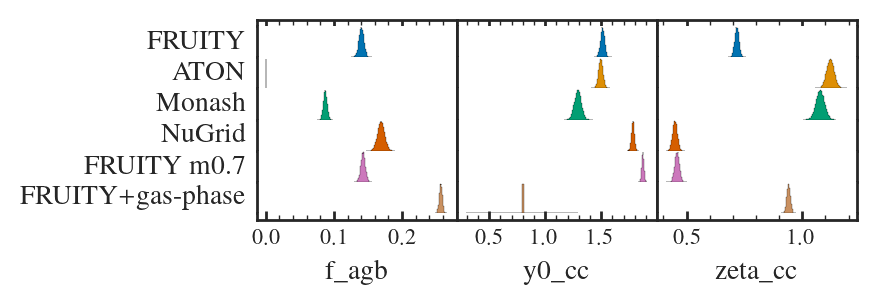

In [62]:
compare_multi_param_hists(results, plot_labels)

In [88]:
plot_labels = {
    "fruity": r"FRUITY",
    "fiducial_constrained": r"+gas",
    "aton": r"ATON",
    "aton_constrained": r"+gas",
    "monash": r"Monash",
    "monash_constrained": r"+gas",
    "nugrid": r"NuGrid",
    "nugrid_constrained": r"+gas",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

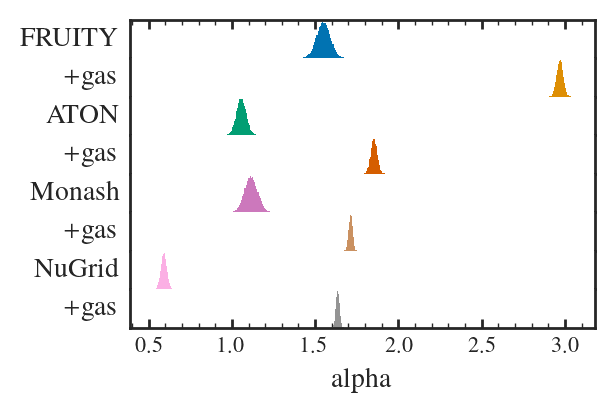

In [89]:
compare_param_hists(results, plot_labels, "alpha")

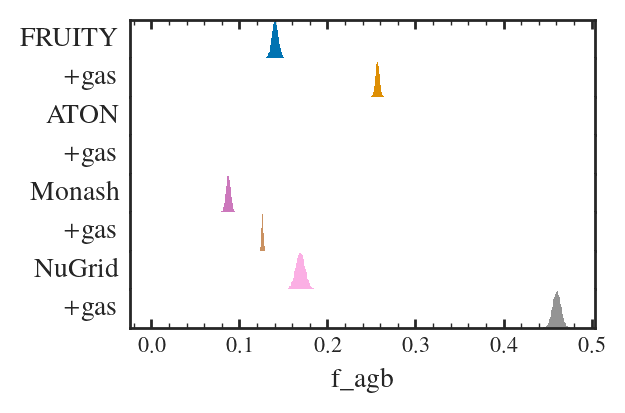

In [91]:
compare_param_hists(results, plot_labels, "f_agb")

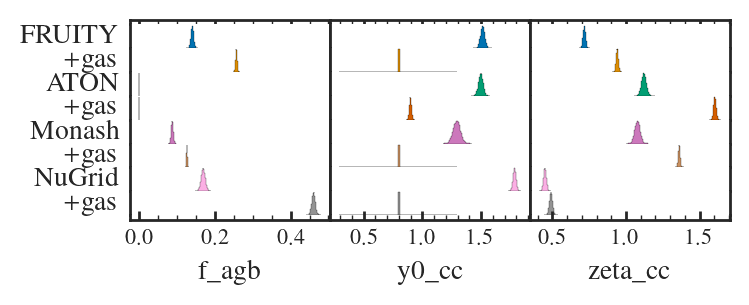

In [90]:
compare_multi_param_hists(results, plot_labels)

In [65]:
plot_labels = {
    "fiducial_constrained": r"FRUITY",
    "aton_constrained": r"ATON",
    "monash_constrained": r"Monash",
    "nugrid_constrained": r"NuGrid",
}

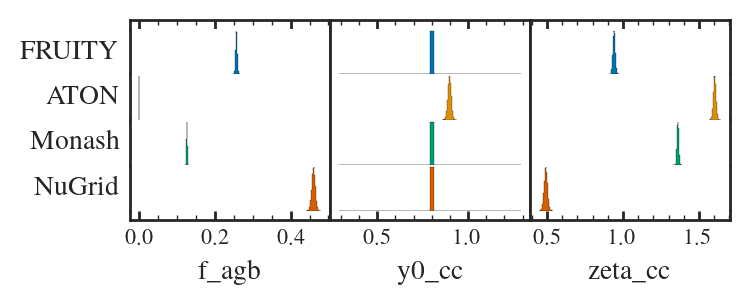

In [66]:
compare_multi_param_hists(results, plot_labels)

In [1]:
plot_labels = {
    "4spline": r"FRUITY",
    "4spline_aton": r"ATON",
    "4spline_monash": r"Monash",
    "4spline_nugrid": r"NuGrid",
}

In [2]:
compare_multi_param_hists(results, plot_labels, ["f_agb", "spline_0", "spline_1", "spline_2", "spline_3"])

NameError: name 'compare_multi_param_hists' is not defined

In [121]:
plot_labels = {
    "fruity": r"FRUITY",
    "fiducial_constrained": r"constrained",
    "4spline": r"spline",
    #"fiducial_spline": r"8spline",
    "aton": r"ATON",
    "aton_constrained": r"constrained",
    "4spline_aton": r"spline",
     "monash": r"Monash",
     "monash_constrained": r"constrained",
     "4spline_monash": r"spline",
     "nugrid": r"NuGrid",
    "nugrid_constrained": r"constrained",
    "4spline_nugrid": r"spline",
}

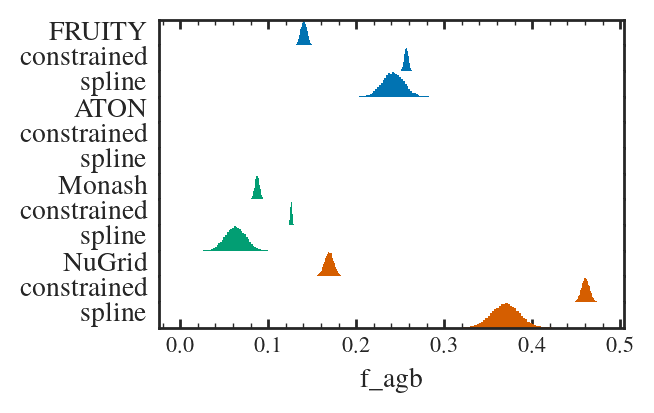

In [122]:
compare_param_hists(results, plot_labels, "f_agb", colors=np.repeat(arya.COLORS, 3))

In [116]:
plot_labels = {
    "fruity_sigma": r"FRUITY",
    "aton_sigma": r"ATON",
    "monash_sigma": r"Monash",
    "nugrid_sigma": r"NuGrid",
    "fruity_m0.7_sigma": r"FRUITY m0.7",
    "fiducial_constrained_sigma": r"FRUITY+gas-phase",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

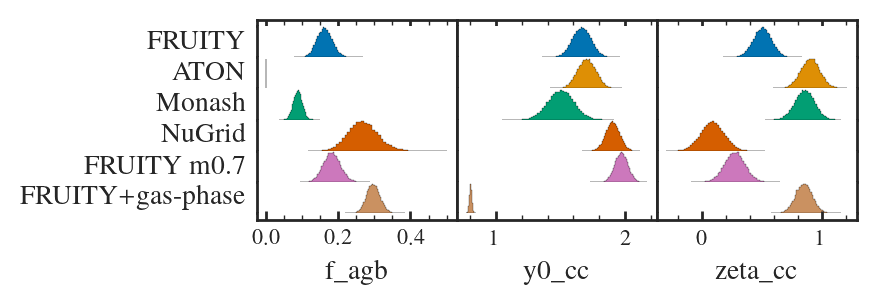

In [117]:
compare_multi_param_hists(results, plot_labels)

In [69]:
plot_labels = {
    "fruity_4": r"FRUITY",
    "aton_sigma": r"ATON",
    "monash_sigma": r"Monash",
    "nugrid_sigma": r"NuGrid",
    "fruity_m0.7_sigma": r"FRUITY m0.7",
    "fiducial_constrained_sigma": r"FRUITY+gas-phase",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

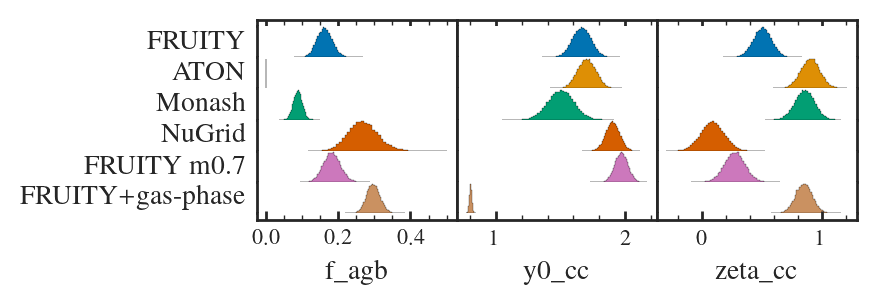

In [70]:
compare_multi_param_hists(results, plot_labels)

In [80]:
plot_labels = {
    "fiducial": r"FRUITY",
    "fiducial_constrained": r"+gas-phase",
    "fiducial_1d": r"1D",
    "fiducial_sigma": r"+sigma",
    "4spline": r"4spline",
    "fiducial_spline": r"8spline",
    "fiducial_spline_1d": "1D 8spline",
}

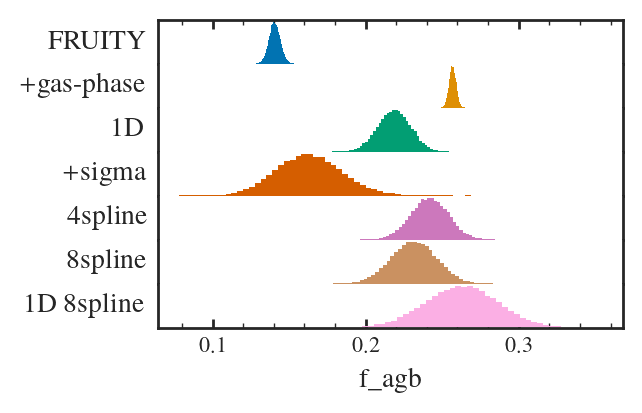

In [81]:
compare_param_hists(results, plot_labels, "f_agb")

In [90]:
plot_labels = {
    "fiducial": r"FRUITY",
    "fiducial_constrained": "+ gas phase",
    "eta2": r"$y\rightarrow 2y$",
    "eta2_constrained": "+ gas phase",
    "lateburst": r"lateburst",
    "lateburst_constrained": "+ gas phase",
    "twoinfall": r"twoinfall",
    "twoinfall_constrained": "+ gas phase",
    "sneia_1.2": r"SNIa 1.2x",
    "sneia_1.2_constrained": "+ gas phase",
}

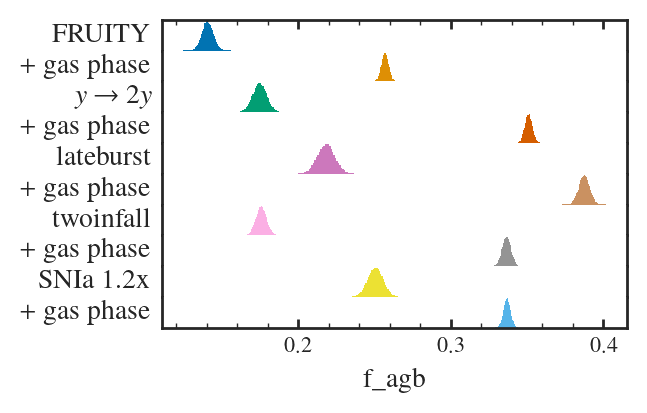

In [91]:
compare_param_hists(results, plot_labels, "f_agb")

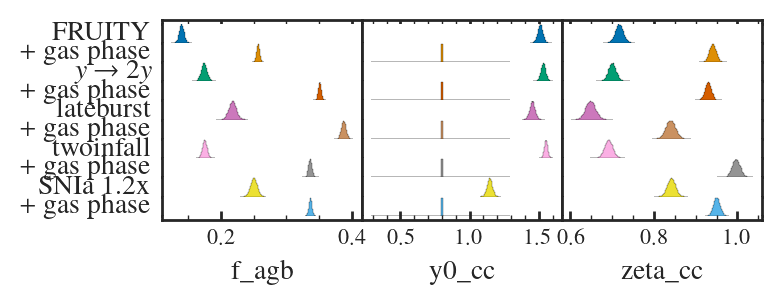

In [75]:
compare_multi_param_hists(results, plot_labels)

In [82]:
plot_labels = {
    "fruity": r"APOGEE subgiants",
    "fiducial_constrained": r"+constrained",
    "galah": r"Galah",
    "galah_constrained": r"+constrained",
    "gso": r"{\it Gaia}--ESO",
    "gso_constrained": r"+constrained",
    "v21": r"Vincenzo+2021",
    "v21_constrained" : "+constrained"
}

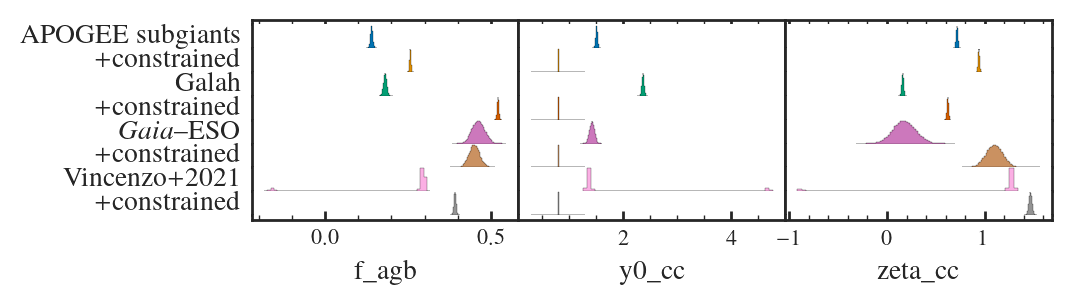

In [77]:
axs = compare_multi_param_hists(results, plot_labels)
set_size(4, 1)

In [101]:
plot_labels = {
    "fruity": "fiducial    ",
    "4spline": "+spline",
    "fiducial_constrained": "constrained",
    "galah": r"Galah       ",
    "4spline_galah": r"+spline",
    "galah_constrained": r"+constrained",
    "gso": r"{\it Gaia}--ESO     ",
    "4spline_gso": r"+spline",
    "gso_constrained": r"+constrained",
    "v21": r"Vincenzo+2021     ",
    "4spline_v21" : "+spline",
    "v21_constrained" : "+constrained"

}

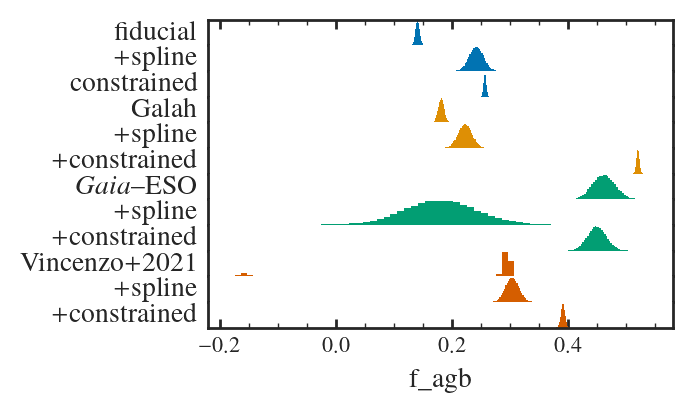

In [102]:
compare_param_hists(results, plot_labels, "f_agb", colors=np.repeat(arya.COLORS, 3))

In [83]:
plot_labels = {
    "fruity": r"fiducial",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
    "eta2": r"eta2",
 "sneia_1.2": "SNIa x 1.2"
}

(0.1, 0.582161778780228)

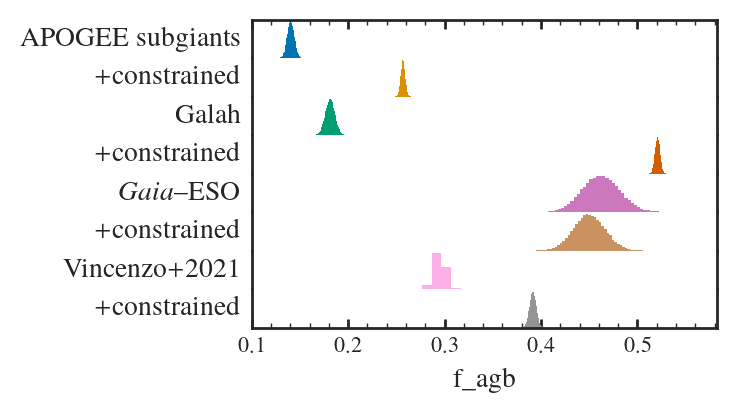

In [84]:
compare_param_hists(results, plot_labels, "f_agb")
plt.xlim(0.1)

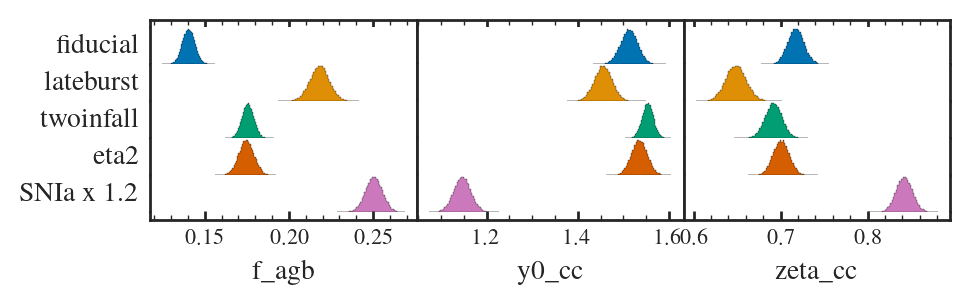

In [84]:
compare_multi_param_hists(results, plot_labels)

set_size(4, 1)

## Tabulated properties